In [2]:
from ultralytics import YOLO
import cv2
import torch
import numpy as np
from collections import Counter
img_path = "SoccerNet/calibration/test/00000.jpg"

model = YOLO("yolov8n.pt")
model_line = YOLO("yolov8n_line_detail.pt")  
model.to('cuda' if torch.cuda.is_available() else 'cpu')
model_line.to('cuda' if torch.cuda.is_available() else 'cpu')
print("Model loaded")

Model loaded


In [ ]:
frame = cv2.imread(img_path)
results = model.predict(frame, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False)
lines = model_line.predict(frame, device='cuda' if torch.cuda.is_available() else 'cpu', verbose=False)
annotated_frame = frame.copy()
field_map = {
    # LÍNEAS DE BORDE
    "Side line left":     (0, 0, 0, 68),
    "Side line right":    (105, 0, 105, 68),
    "Side line top":      (0, 68, 105, 68),
    "Side line bottom":   (0, 0, 105, 0),
    "Middle line":        (52.5, 0, 52.5, 68),

    # CÍRCULOS
    "Circle central":     {"center": (52.5, 34), "radius": 9.15},

    # ÁREA GRANDE IZQUIERDA
    "Big rect. left main":   (16.5, 13.85, 16.5, 54.15),
    "Big rect. left top":    (0, 54.15, 16.5, 54.15),
    "Big rect. left bottom": (0, 13.85, 16.5, 13.85),

    # ÁREA GRANDE DERECHA
    "Big rect. right main":   (88.5, 13.85, 88.5, 54.15),
    "Big rect. right top":    (105, 54.15, 88.5, 54.15),
    "Big rect. right bottom": (105, 13.85, 88.5, 13.85),

    # ÁREA CHICA IZQUIERDA
    "Small rect. left main":   (5.5, 24.84, 5.5, 43.16),
    "Small rect. left top":    (0, 43.16, 5.5, 43.16),
    "Small rect. left bottom": (0, 24.84, 5.5, 24.84),

    # ÁREA CHICA DERECHA
    "Small rect. right main":   (99.5, 24.84, 99.5, 43.16),
    "Small rect. right top":    (105, 43.16, 99.5, 43.16),
    "Small rect. right bottom": (105, 24.84, 99.5, 24.84),
}

def segment_to_line(x1, y1, x2, y2, name):
    A = y2 - y1
    B = x1 - x2
    C = x2 * y1 - x1 * y2
    return A, B, -C, name

def intersection(line1, line2):
    A1, B1, C1, NAME1 = line1
    A2, B2, C2, NAME2 = line2
    D = A1 * B2 - A2 * B1
    if D == 0:
        return None  # Son paralelas
    x = (B2 * C1 - B1 * C2) / D
    y = (A1 * C2 - A2 * C1) / D
    return x, y, NAME1, NAME2



positions = []
index = 0
for result in results:
    boxes = result.boxes
    detections = []
    for box in boxes:
        cls_id = int(box.cls[0])  # Clase detectada
        if model.names[cls_id] == 'person':
            x1, y1, x2, y2 = box.xyxy[0].tolist()  
            x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
            #print(f"Person detected: {x1}, {y1}, {x2}, {y2}, {model.names[cls_id]}, {index}")
            positions.append({"pos":((x1+x2)/2, max(y1, y2)),"type": model.names[cls_id], "index": index})
            person_section = annotated_frame[y1:y2, x1:x2]
            small_section = cv2.resize(person_section, (20, 20), interpolation=cv2.INTER_LINEAR)
            hsv_section = cv2.cvtColor(small_section, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(hsv_section, np.array([35, 40, 40]), np.array([85, 255, 255]))
            non_green_pixels = hsv_section[mask == 0]
            quantized_pixels = (non_green_pixels // 32) * 32
            pixels = quantized_pixels.reshape(-1, 3)
            pixels_list = [tuple(pixel) for pixel in pixels]
            if len(pixels_list) > 0:
                most_common = Counter(pixels_list).most_common(1)[0][0]
                domimant_color_rgb = cv2.cvtColor(np.uint8([[most_common]]), cv2.COLOR_HSV2BGR)[0][0]
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), tuple(int(c) for c in domimant_color_rgb), 2)
            else:
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(annotated_frame, str(index), (int((x1+x2)/2), int(max(y1, y2))-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            #ponemos un punto en la posicion de la persona
            cv2.circle(annotated_frame, (int((x1+x2)/2), int(max(y1, y2))), 5, (0, 255, 0), -1)
            index += 1
        #balon
        if model.names[cls_id] == 'sports ball':
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
            positions.append({"pos":((x1+x2)/2, min(y1, y2)),"type": model.names[cls_id], "index": index})
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(annotated_frame, str(index), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            index += 1
# Dibuja las líneas detectadas
field_lines = []
for line in lines:
    boxes = line.boxes
    for box in boxes:
        cls_id = int(box.cls[0])
        if model_line.names[cls_id] in ['Circle right', 'Circle central', 'Circle left']:
            """ x1, y1, x2, y2 = box.xyxy[0].tolist()
            x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
            #creamos una linea entre los puntos
            #cv2.line(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            #anotamos la clase
            cv2.putText(annotated_frame, model_line.names[cls_id], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2) """
            pass
        elif model_line.names[cls_id] in ["Goal right crossbar","Goal right post left","Goal right post right","Goal left post left","Goal left post left ","Goal left post left","Goal left post right","Goal left crossbar", 'unknown']:
            """ cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
            #anotamos la clase
            cv2.putText(annotated_frame, model_line.names[cls_id], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2) """
            pass
        else:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            x1, y1, x2, y2 = map(int, (x1, y1, x2, y2))
            #vamos a hacer deteccion de bordes en esta zona
            roi = annotated_frame[y1:y2, x1:x2]
            # Convertir a escala de grises
            gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            # Aplicar un filtro de suavizado
            blurred_roi = cv2.GaussianBlur(gray_roi, (5, 5), 0)
            # Aplicar Canny para detectar bordes
            edges = cv2.Canny(gray_roi, 50, 150)
            # mostrar los bordes
            lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=20, maxLineGap=10)

            if lines is not None:
                angles = []
                for line in lines:
                    x1_line, y1_line, x2_line, y2_line = line[0]
                    # Calcular dirección en grados
                    angle_rad = np.arctan2((y2_line - y1_line), (x2_line - x1_line))
                    angle_deg = np.degrees(angle_rad)
                    angles.append(angle_deg)
                    #cv2.line(annotated_frame, (x1 + x1_line, y1 + y1_line), (x1 + x2_line, y1 + y2_line), (0, 255, 255), 2)
                # Calcular el ángulo promedio
                if len(angles) > 0:
                    avg_angle = np.mean(angles)
                    if avg_angle > 0:
                        cv2.line(annotated_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        field_lines.append({"pos":(x1, y1, x2, y2),"type": model_line.names[cls_id]})
                    else:
                        cv2.line(annotated_frame, (x1, y2), (x2, y1), (0, 255, 0), 2)
                        field_lines.append({"pos":(x1, y2, x2, y1),"type": model_line.names[cls_id]})
            #cv2.putText(annotated_frame, model_line.names[cls_id], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)                   
intersections = []
names = []           
for i, line1 in enumerate(field_lines):
    for j, line2 in enumerate(field_lines):
        if i >= j:
            continue
        if line1 != line2:
            pos1 = line1["pos"]
            pos2 = line2["pos"]
            # Convertir las coordenadas de la línea a la forma Ax + By + C = 0
            A1, B1, C1, NAME1 = segment_to_line(pos1[0], pos1[1], pos1[2], pos1[3], line1["type"])
            A2, B2, C2, NAME2 = segment_to_line(pos2[0], pos2[1], pos2[2], pos2[3], line2["type"])
            # Calcular la intersección
            intersection_point = intersection((A1, B1, C1, NAME1), (A2, B2, C2, NAME2))
            if intersection_point is not None:
                x, y, name1, name2 = intersection_point
                if x > 0 and y >0:
                    intersections.append({"pos":(x, y),"lines": (name1, name2)})
                    names.append((name1, name2))
                    cv2.circle(annotated_frame, (int(intersection_point[0]), int(intersection_point[1])), 5, (255, 255, 0), -1)
                    cv2.putText(annotated_frame, f"{intersection_point[2]}-{intersection_point[3]}", (int(intersection_point[0]), int(intersection_point[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.1, (0, 255, 255), 2)      
                

#Lineas de campo
field_lines_map = []
for name, coords in field_map.items():
    if isinstance(coords, tuple):  # es una línea
        x1, y1, x2, y2 = coords
        field_lines_map.append(segment_to_line(x1, y1, x2, y2, name))
        
# Intersección de líneas del campo        
intersections_field = []
for i, line1 in enumerate(field_lines_map):
    for j, line2 in enumerate(field_lines_map):
        if i >= j:
            continue
        point = intersection(line1, line2)
        if point is not None:
            x, y, name1, name2 = point
            if (name1, name2) in names or (name2, name1) in names:
                intersections_field.append({
                    "pos": (x, y),
                    "lines": (name1, name2)
                })              

matched_pairs = []
for i in intersections:
    for f in intersections_field:
        if set(i["lines"]) == set(f["lines"]):
            matched_pairs.append((i["pos"], f["pos"]))  # (imagen, cancha)
            break

# Homografía 2d
positions_homography = []
intersection_homography = []        
if len(matched_pairs) > 4:
    
    src_pts = np.array([pt[0] for pt in matched_pairs], dtype=np.float32)
    dst_pts = np.array([pt[1] for pt in matched_pairs], dtype=np.float32)
    
    # Calcular la homografía
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
    print("Homografía calculada")
    # Aplicar la homografía a los puntos de la imagen
    for pos in positions:
        point = np.array([pos["pos"][0], pos["pos"][1], 1], dtype=np.float32)
        transformed_point = np.dot(H, point)
        transformed_point /= transformed_point[2]  # Normalizarq
        positions_homography.append({"pos":(transformed_point[0], transformed_point[1]),"type": pos["type"], "index": pos["index"]})
    # Aplicar la homografía a los puntos de intersección
    for pos in intersections:
        point = np.array([pos["pos"][0], pos["pos"][1], 1], dtype=np.float32)
        transformed_point = np.dot(H, point)
        transformed_point /= transformed_point[2]  # Normalizar
        intersection_homography.append({"pos":(transformed_point[0], transformed_point[1]),"lines": pos["lines"]})              
                
cv2.imshow("Detecciones", annotated_frame)
# Esperar hasta que se presione una tecla
cv2.waitKey(0)
cv2.destroyAllWindows()

Homografía calculada


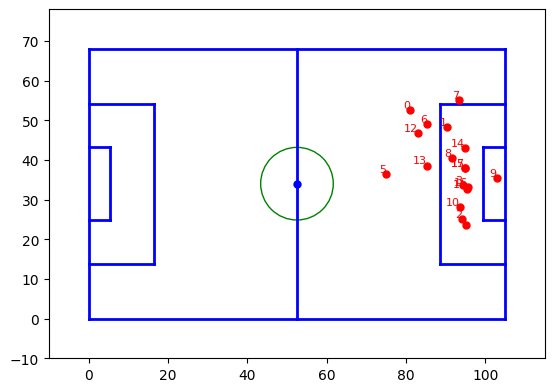

In [27]:
#plotear el campo
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, ax = plt.subplots()
ax.set_xlim(-10, 115)
ax.set_ylim(-10, 78)
ax.set_aspect('equal')

#dibujamos "Side line left"
for line in field_map:
    if line == "Side line left":
        x1, y1, x2, y2 = field_map[line]
        ax.plot([x1, x2], [y1, y2], color='blue', linewidth=2)
    elif line == "Side line right":
        x1, y1, x2, y2 = field_map[line]
        ax.plot([x1, x2], [y1, y2], color='blue', linewidth=2)
    elif line == "Side line top":
        x1, y1, x2, y2 = field_map[line]
        ax.plot([x1, x2], [y1, y2], color='blue', linewidth=2)
    elif line == "Side line bottom":
        x1, y1, x2, y2 = field_map[line]
        ax.plot([x1, x2], [y1, y2], color='blue', linewidth=2)
    elif line == "Middle line":
        x1, y1, x2, y2 = field_map[line]
        ax.plot([x1, x2], [y1, y2], color='blue', linewidth=2)
        center_x = field_map[line][0]
        center_y = field_map[line][3] / 2
        ax.plot([center_x], [center_y], marker='o', markersize=5, color='blue')
    else:
        if isinstance(field_map[line], dict):
            circle = patches.Circle((field_map[line]["center"][0], field_map[line]["center"][1]), radius=field_map[line]["radius"], edgecolor='green', facecolor='none')
            ax.add_patch(circle)
        else:
            x1, y1, x2, y2 = field_map[line]
            ax.plot([x1, x2], [y1, y2], color='blue', linewidth=2)

#dibujamos un circulo en las posiciones homografía
for pos in positions_homography:
    if pos["type"] == "person":
        color = "red"
    elif pos["type"] == "sports ball":
        color = "blue"
    else:
        color = "green"
    ax.plot([pos["pos"][0]], [pos["pos"][1]], marker='o', markersize=5, color=color)
    ax.text(pos["pos"][0], pos["pos"][1], str(pos["index"]), fontsize=8, ha='right', va='bottom', color=color)
